PREDICCIÓN ESTADIO MELANOMA: VARIABLES CLÍNICAS

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pycaret.classification import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

CARGAR LOS DATOS

In [2]:
df = pd.read_csv('df_truetarget.csv')
df.head()

,Subtype,TCGA PanCanAtlas Cancer Type Acronym,Other Patient ID,Diagnosis Age,Sex,Neoplasm Disease Stage American Joint Committee on Cancer Code,American Joint Committee on Cancer Publication Version Type,Last Communication Contact from Initial Pathologic Diagnosis Date,Birth from Initial Pathologic Diagnosis Date,Last Alive Less Initial Pathologic Diagnosis Date Calculated Day Value,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,trueTarget
0,SKCM,SKCM,5564E6A7-2195-4B0D-994E-B0617B58E889,71.0,Male,STAGE IA,7TH,NaN,-26176,0.0,...,1.5289,-1.4791,-1.0775,-0.5874,0.7428,-0.2728,-2.0876,-2.2139,-0.1152,False
1,SKCM,SKCM,551E071A-C290-4B48-9000-F64C2A44DFB7,82.0,Male,STAGE IIA,6TH,2022.0,-30286,0.0,...,-0.5350,0.5245,0.2616,0.3533,-0.7334,-0.1408,-0.3072,-1.2198,0.6850,False
2,SKCM,SKCM,A29A20E3-5C2C-4F37-B93E-AE9EBC46EC53,82.0,Male,STAGE IIIA,7TH,NaN,-30163,0.0,...,-0.5780,-0.6422,-0.2198,0.6876,1.4183,0.2610,-0.4649,-0.5828,-0.0017,False
3,NaN,SKCM,3DD5A206-D7F3-42F1-B9CC-4B31C76D495D,46.0,Female,STAGE IIC,7TH,387.0,-17025,0.0,...,-0.0718,-0.1132,-0.1148,0.3637,-1.3046,-1.0278,0.2870,0.7965,-1.7373,True
4,NaN,SKCM,EFF78AF6-0F68-49B9-866B-0D511606F2B1,74.0,Female,STAGE IIC,7TH,14.0,-27124,0.0,...,0.4944,0.6672,0.3759,-0.7236,-1.3046,0.5597,0.2858,-0.6041,1.3473,True


EXPLORACIÓN DE LOS DATOS

In [3]:
print(df.shape)
df.info()

(436, 20549)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Columns: 20549 entries, Subtype to trueTarget
dtypes: bool(1), float64(20520), object(28)
memory usage: 68.4+ MB


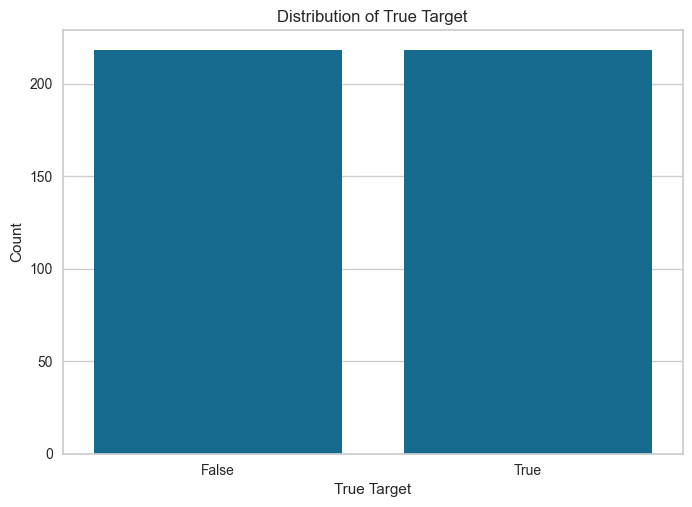

In [4]:
sns.countplot(x='trueTarget', data=df)
plt.title('Distribution of True Target')
plt.xlabel('True Target')
plt.ylabel('Count')
plt.show()

In [5]:
print(df.columns[:40])

Index(['Subtype', 'TCGA PanCanAtlas Cancer Type Acronym', 'Other Patient ID',
       'Diagnosis Age', 'Sex',
       'Neoplasm Disease Stage American Joint Committee on Cancer Code',
       'American Joint Committee on Cancer Publication Version Type',
       'Last Communication Contact from Initial Pathologic Diagnosis Date',
       'Birth from Initial Pathologic Diagnosis Date',
       'Last Alive Less Initial Pathologic Diagnosis Date Calculated Day Value',
       'Ethnicity Category', 'Form completion date',
       'Neoadjuvant Therapy Type Administered Prior To Resection Text',
       'ICD-10 Classification',
       'International Classification of Diseases for Oncology, Third Edition ICD-O-3 Histology Code',
       'International Classification of Diseases for Oncology, Third Edition ICD-O-3 Site Code',
       'Informed consent verified',
       'New Neoplasm Event Post Initial Therapy Indicator',
       'American Joint Committee on Cancer Metastasis Stage Code',
       'Neoplasm 

PREPROCESAMIENTO DE LOS DATOS

In [6]:
clinicas_num = [
    'Diagnosis Age'
]

clinicas_cat = [
    'Sex', 'Race Category', 'Ethnicity Category',
    'Radiation Therapy', 'Neoadjuvant Therapy Type Administered Prior To Resection Text',
    'Genetic Ancestry Label'
]
df_clinico = df[clinicas_num + clinicas_cat + ['trueTarget']]
df_clinico = df_clinico.reset_index(drop=True)
df_clinico.shape

(436, 8)

In [7]:
datos_faltantes = df_clinico.isna().sum()
porcentaje_na = (datos_faltantes / len(df_clinico)) * 100
print(porcentaje_na)

Diagnosis Age                                                    1.605505
Sex                                                              0.000000
Race Category                                                    1.834862
Ethnicity Category                                               2.752294
Radiation Therapy                                                1.605505
Neoadjuvant Therapy Type Administered Prior To Resection Text    0.000000
Genetic Ancestry Label                                           0.000000
trueTarget                                                       0.000000
dtype: float64


In [8]:
df_clinico.dropna(inplace=True)
df_clinico.shape

(406, 8)

In [9]:
X = df_clinico.drop(columns=['trueTarget'])
y = df_clinico['trueTarget']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))
print(y.value_counts(normalize=True))

False    0.503086
True     0.496914
Name: trueTarget, dtype: float64
False    0.5
True     0.5
Name: trueTarget, dtype: float64
False    0.502463
True     0.497537
Name: trueTarget, dtype: float64


CODIFICAMOS VARIABLES

In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), clinicas_num),
        ('cat', OneHotEncoder(handle_unknown='ignore'), clinicas_cat)
    ]
)

In [11]:
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)
print(X_train_prep.shape)
column_names = clinicas_num + list(preprocessor.named_transformers_['cat'].get_feature_names_out(clinicas_cat))

(324, 15)


In [12]:
df_final_train = pd.DataFrame(X_train_prep.toarray() if hasattr(X_train_prep, 'toarray') else X_train_prep,
                                     columns=column_names)
df_final_train['trueTarget'] = y_train.values

df_final_test = pd.DataFrame(X_test_prep.toarray() if hasattr(X_test_prep, 'toarray') else X_test_prep,
                                    columns=column_names)
df_final_test['trueTarget'] = y_test.values

In [13]:
df_final_train.columns = (
    df_final_train.columns
    .str.replace('[^A-Za-z0-9_]+', '_', regex=True)
    .str.replace('_+', '_', regex=True)
    .str.strip('_')
)
df_final_test.columns = (
    df_final_test.columns
    .str.replace('[^A-Za-z0-9_]+', '_', regex=True)
    .str.replace('_+', '_', regex=True)
    .str.strip('_')
)

In [14]:
df_final_train.head()

,Diagnosis_Age,Sex_Female,Sex_Male,Race_Category_Asian,Race_Category_White,Ethnicity_Category_Hispanic_Or_Latino,Ethnicity_Category_Not_Hispanic_Or_Latino,Radiation_Therapy_No,Radiation_Therapy_Yes,Neoadjuvant_Therapy_Type_Administered_Prior_To_Resection_Text_No,Neoadjuvant_Therapy_Type_Administered_Prior_To_Resection_Text_Yes,Genetic_Ancestry_Label,Genetic_Ancestry_Label_AMR,Genetic_Ancestry_Label_EAS,Genetic_Ancestry_Label_EUR,trueTarget
0,0.063468,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,True
1,-0.125190,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,True
2,1.698503,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,False
3,-0.188076,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,True
4,-0.942707,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,False


In [15]:
print(y_train.value_counts())
print(y_train.value_counts(normalize=True))
print(df_final_train.shape)
print(df_final_test.shape)
print((df_final_train.columns == df_final_test.columns).all())

False    163
True     161
Name: trueTarget, dtype: int64
False    0.503086
True     0.496914
Name: trueTarget, dtype: float64
(324, 16)
(82, 16)
True


CORRELACIÓN DE VARIABLES

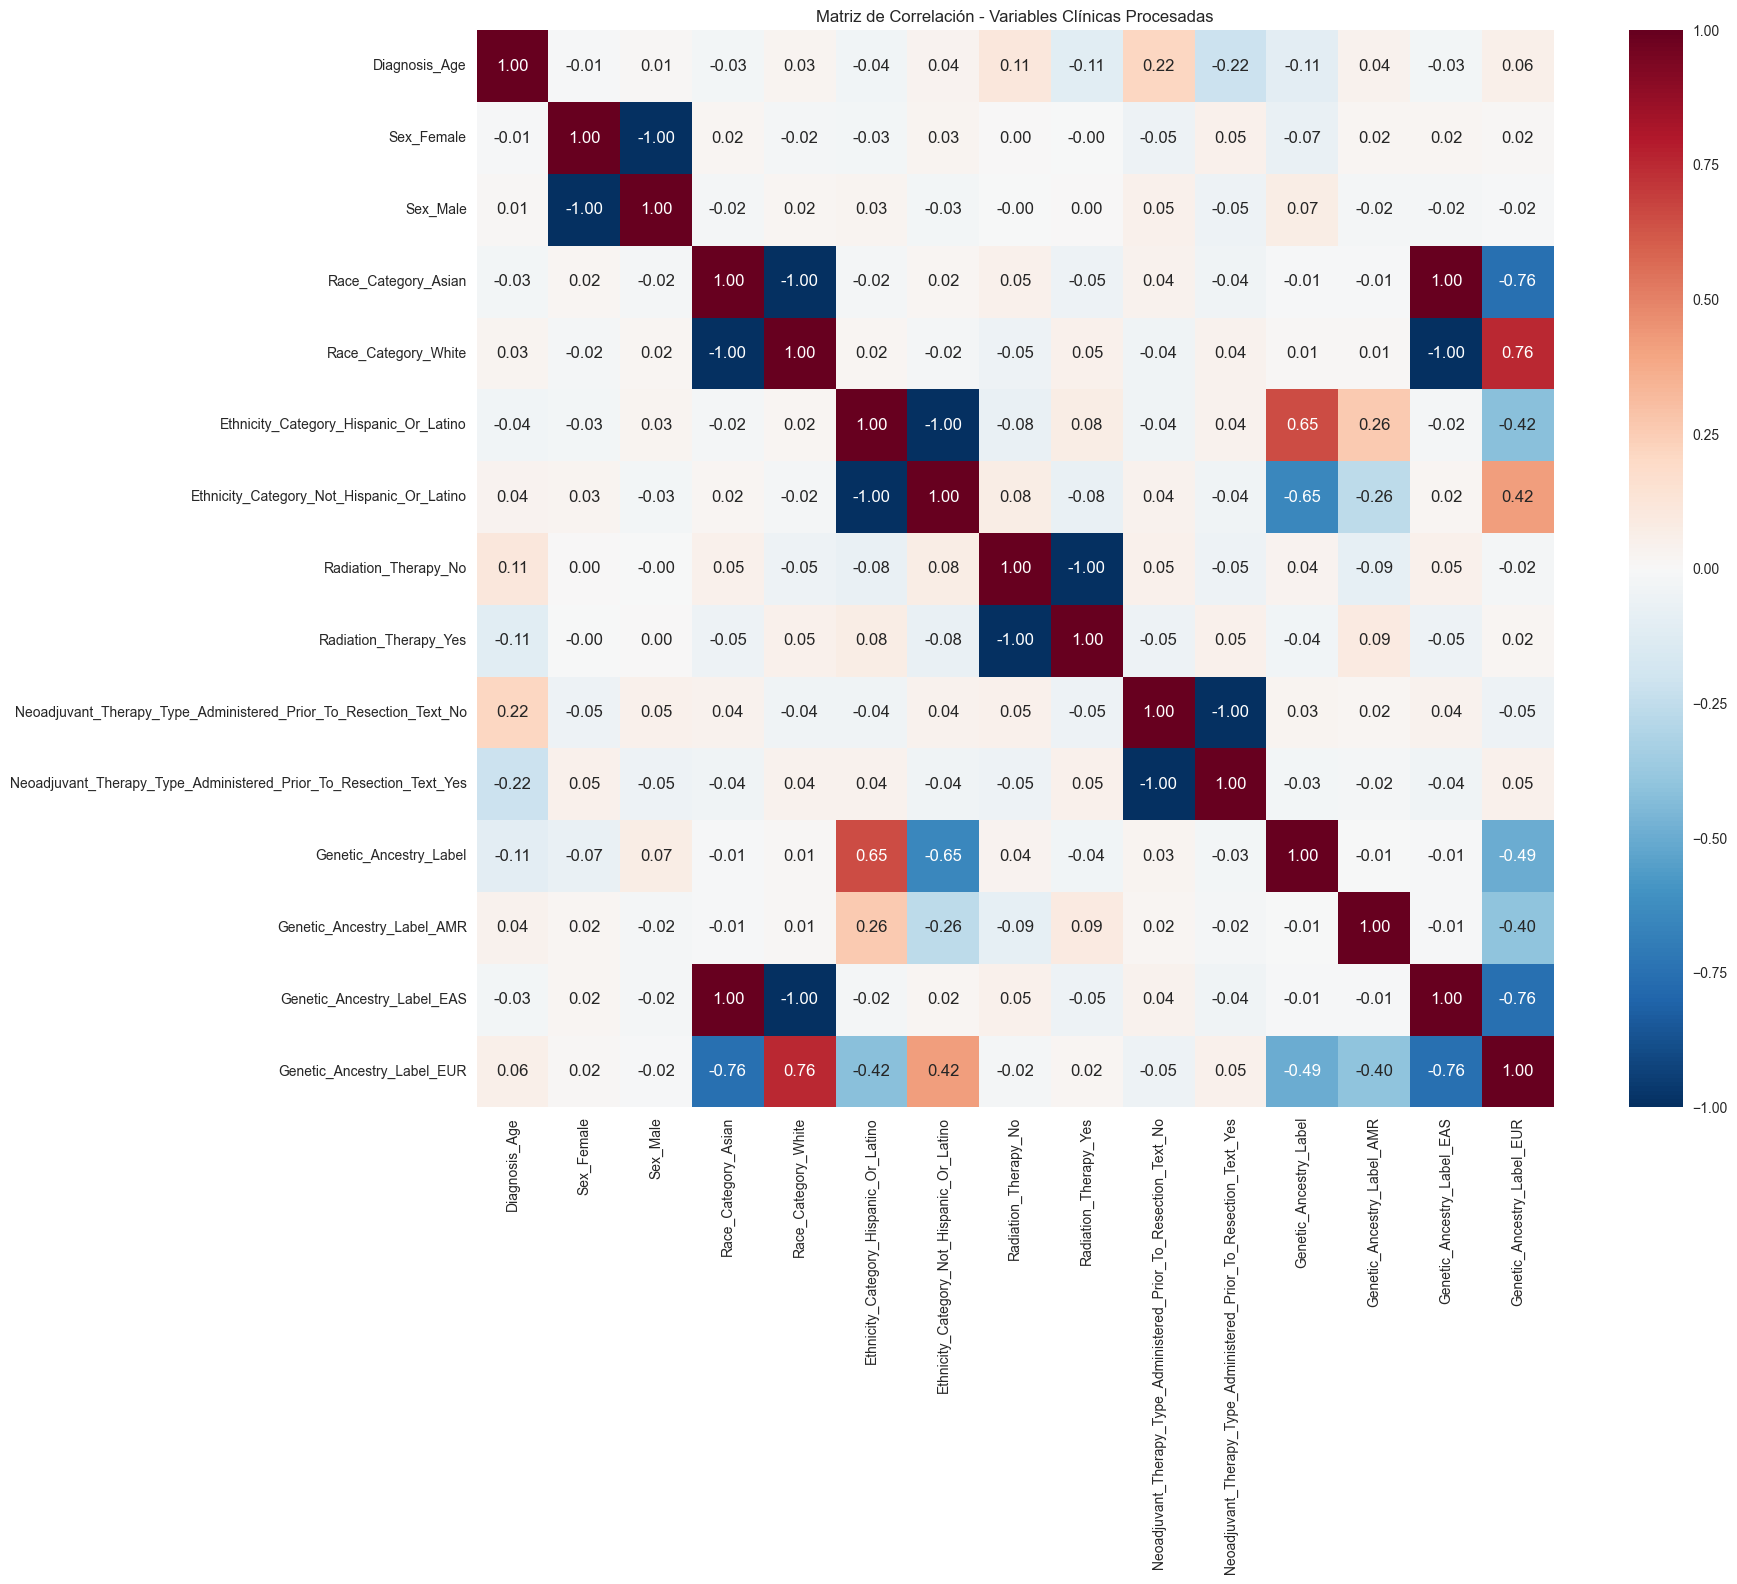

In [16]:
plt.figure(figsize=(20, 16))

numeric_data = df_final_train.select_dtypes(include=[np.number])

correlation_matrix = numeric_data.corr()

sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='RdBu_r', 
            center=0,
            square=True,
            fmt='.2f')

plt.title('Matriz de Correlación - Variables Clínicas Procesadas')
plt.tight_layout()
plt.show()

PYCARET PARA ENCONTRAR EL MEJOR MODELO

In [17]:
clf = setup(data=df_final_train, target='trueTarget', session_id=42, index = False, test_data= df_final_test)
best_model = compare_models(sort = 'f1')
print(best_model)

,Description,Value
0,Session id,42
1,Target,trueTarget
2,Target type,Binary
3,Original data shape,"(406, 16)"
4,Transformed data shape,"(406, 16)"
5,Transformed train set shape,"(324, 16)"
6,Transformed test set shape,"(82, 16)"
7,Numeric features,15
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.5152,0.6313,0.9500,0.5104,0.6616,0.0342,0.0384,0.0160
lda,Linear Discriminant Analysis,0.6107,0.6482,0.6213,0.6072,0.6118,0.2215,0.2230,0.0150
gbc,Gradient Boosting Classifier,0.5925,0.6201,0.6349,0.5776,0.6023,0.1860,0.1902,0.0550
ridge,Ridge Classifier,0.6045,0.0000,0.6099,0.6008,0.6020,0.2098,0.2114,0.0170
lr,Logistic Regression,0.6046,0.6490,0.6037,0.6032,0.5990,0.2101,0.2125,1.1790
qda,Quadratic Discriminant Analysis,0.5000,0.0000,0.9000,0.4485,0.5986,0.0000,0.0000,0.0160
lightgbm,Light Gradient Boosting Machine,0.6076,0.6307,0.5971,0.6047,0.5976,0.2153,0.2180,0.0930
ada,Ada Boost Classifier,0.5800,0.6131,0.6147,0.5733,0.5910,0.1603,0.1632,0.0530
knn,K Neighbors Classifier,0.5795,0.5716,0.5404,0.5640,0.5473,0.1586,0.1571,0.0280
xgboost,Extreme Gradient Boosting,0.5430,0.5969,0.5482,0.5330,0.5306,0.0883,0.0901,0.0570


GaussianNB(priors=None, var_smoothing=1e-09)


TUNEAMOS EL MODELO

In [18]:
lr = create_model('lr')
tuned_lr = tune_model(lr, optimize='f1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5152,0.5974,0.4118,0.5385,0.4667,0.0365,0.0376
1,0.6667,0.7188,0.6875,0.6471,0.6667,0.3339,0.3346
2,0.6364,0.6268,0.6250,0.6250,0.6250,0.2721,0.2721
3,0.6970,0.7408,0.7500,0.6667,0.7059,0.3956,0.3985
4,0.5938,0.7109,0.7500,0.5714,0.6486,0.1875,0.1974
5,0.5938,0.6855,0.6250,0.5882,0.6061,0.1875,0.1879
6,0.5625,0.5488,0.4375,0.5833,0.5000,0.1250,0.1291
7,0.4375,0.4590,0.3750,0.4286,0.4000,-0.1250,-0.1260
8,0.8125,0.8223,0.7500,0.8571,0.8000,0.6250,0.6299


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6061,0.6048,0.5882,0.6250,0.6061,0.2128,0.2132
1,0.6667,0.7004,0.6875,0.6471,0.6667,0.3339,0.3346
2,0.6364,0.6305,0.6250,0.6250,0.6250,0.2721,0.2721
3,0.6970,0.7482,0.7500,0.6667,0.7059,0.3956,0.3985
4,0.5938,0.7109,0.7500,0.5714,0.6486,0.1875,0.1974
5,0.5938,0.6973,0.6250,0.5882,0.6061,0.1875,0.1879
6,0.5625,0.5488,0.4375,0.5833,0.5000,0.1250,0.1291
7,0.4688,0.4590,0.4375,0.4667,0.4516,-0.0625,-0.0626
8,0.7812,0.8223,0.7500,0.8000,0.7742,0.5625,0.5636


Fitting 10 folds for each of 10 candidates, totalling 100 fits


VISUALIZACIÓN PRIMER TUNEO

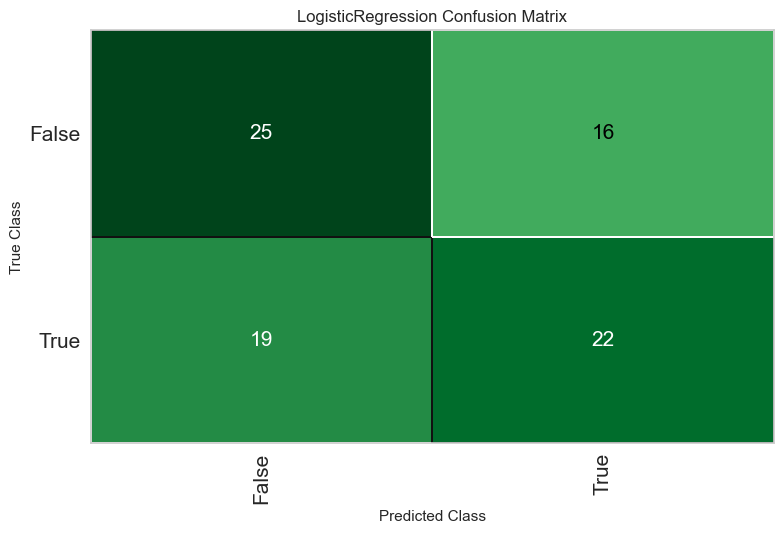

In [19]:
from pycaret.classification import plot_model

plot_model(tuned_lr, plot='confusion_matrix')

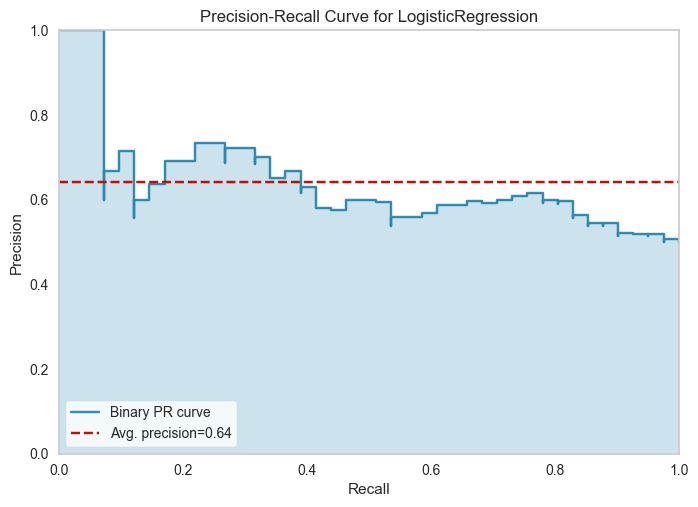

In [20]:
plot_model(tuned_lr, plot='pr')

In [21]:
from pycaret.classification import predict_model
resultados_test = predict_model(tuned_lr, data=df_final_test)
resultados_test.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5732,0.6362,0.5366,0.5789,0.5570,0.1463,0.1467


,Diagnosis_Age,Sex_Female,Sex_Male,Race_Category_Asian,Race_Category_White,Ethnicity_Category_Hispanic_Or_Latino,Ethnicity_Category_Not_Hispanic_Or_Latino,Radiation_Therapy_No,Radiation_Therapy_Yes,Neoadjuvant_Therapy_Type_Administered_Prior_To_Resection_Text_No,Neoadjuvant_Therapy_Type_Administered_Prior_To_Resection_Text_Yes,Genetic_Ancestry_Label,Genetic_Ancestry_Label_AMR,Genetic_Ancestry_Label_EAS,Genetic_Ancestry_Label_EUR,trueTarget,prediction_label,prediction_score
0,-1.194251,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,False,0,0.5907
1,0.503670,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,True,1,0.6229
2,0.000582,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,True,1,0.5608
3,1.195416,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,False,1,0.6374
4,1.635617,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,True,1,0.7467


In [42]:
from sklearn.metrics import classification_report

y_pred = resultados_test['prediction_label']
y_true = resultados_test['trueTarget'].astype(int)

print("Classification Report - Modelo Clínico:")
print(classification_report(y_true, y_pred))

Classification Report - Modelo Clínico:
              precision    recall  f1-score   support

           0       0.57      0.61      0.59        41
           1       0.58      0.54      0.56        41

    accuracy                           0.57        82
   macro avg       0.57      0.57      0.57        82
weighted avg       0.57      0.57      0.57        82



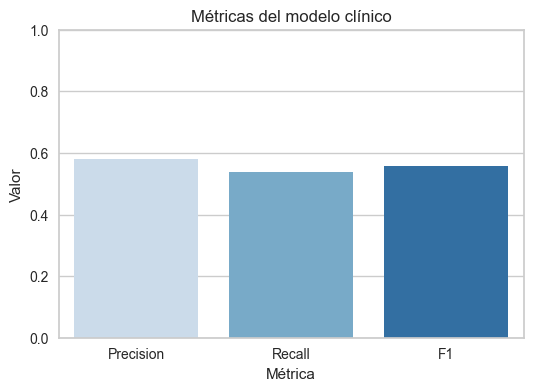

In [43]:
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

import seaborn as sns
import matplotlib.pyplot as plt

metrics_df = pd.DataFrame({
    'Métrica': ['Precision', 'Recall', 'F1'],
    'Valor': [precision, recall, f1]
})

plt.figure(figsize=(6,4))
sns.barplot(data=metrics_df, x='Métrica', y='Valor', palette='Blues')
plt.ylim(0,1)
plt.title('Métricas del modelo clínico')
plt.show()

DISTRIBUCIÓN BAYESIANA

In [22]:
y_test_clean = y_test.map({False: 0, True: 1}).dropna()
y_probas = tuned_lr.predict_proba(X_test_prep)[:, 1]
df_bayesian = pd.DataFrame({
    'Score': y_probas,
    'Clase': y_test_clean.reset_index(drop=True).map({1: 'Agresivo', 0: 'No Agresivo'})
})

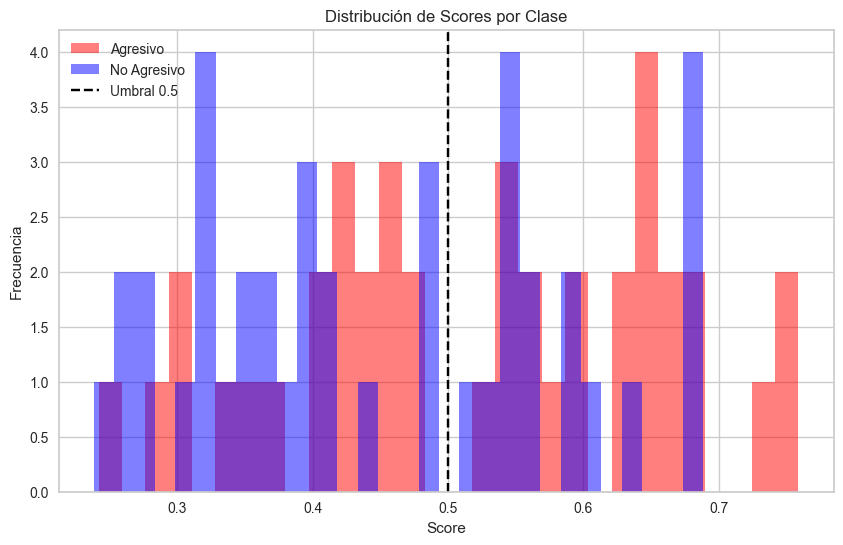

In [23]:
plt.figure(figsize=(10, 6))
plt.hist(df_bayesian[df_bayesian['Clase'] == 'Agresivo']['Score'], bins=30, alpha=0.5, label='Agresivo', color='red')
plt.hist(df_bayesian[df_bayesian['Clase'] == 'No Agresivo']['Score'], bins=30, alpha=0.5, label='No Agresivo', color='blue')
plt.axvline(0.5, color='black', linestyle='--', label='Umbral 0.5')
plt.title('Distribución de Scores por Clase')
plt.xlabel('Score')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

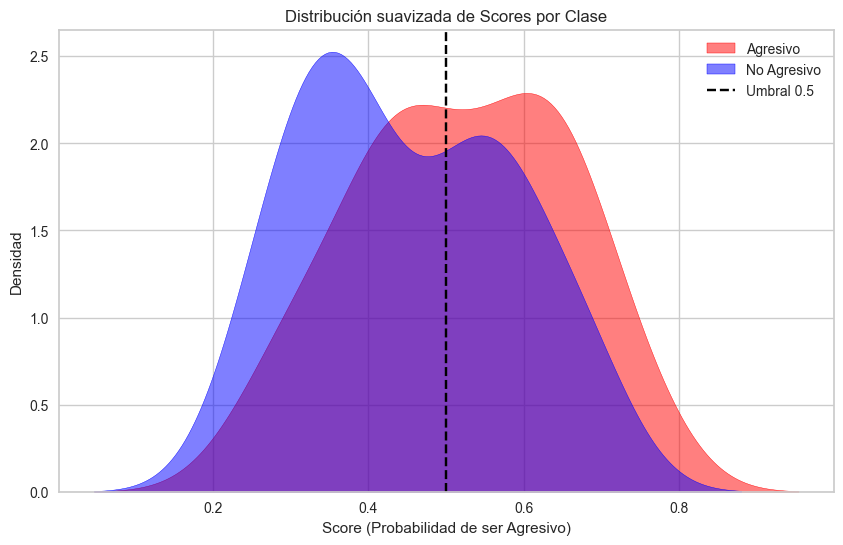

In [24]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df_bayesian[df_bayesian['Clase'] == 'Agresivo']['Score'], label='Agresivo', fill=True, color='red', alpha=0.5)
sns.kdeplot(df_bayesian[df_bayesian['Clase'] == 'No Agresivo']['Score'], label='No Agresivo', fill=True, color='blue', alpha=0.5)
plt.axvline(0.5, color='black', linestyle='--', label='Umbral 0.5')
plt.title('Distribución suavizada de Scores por Clase')
plt.xlabel('Score (Probabilidad de ser Agresivo)')
plt.ylabel('Densidad')
plt.legend()
plt.show()

In [25]:
resultados_test['prediction_score'].min()

0.5118

OPTUNA PARA OPTIMIZAR HIPERPARÁMETROS

In [26]:
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

def objective(trial):
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga', 'lbfgs', 'newton-cg', 'sag'])
    
    # Validar combinaciones válidas
    if penalty == 'l1' and solver not in ['liblinear', 'saga']:
        raise optuna.exceptions.TrialPruned()  # O simplemente return un valor bajo
    if penalty == 'l2' and solver not in ['lbfgs', 'newton-cg', 'sag', 'saga']:
        raise optuna.exceptions.TrialPruned()
    
    params = {
        'C': trial.suggest_float('C', 1e-3, 1e2, log=True),
        'penalty': penalty,
        'solver': solver,
        'max_iter': 1000,
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced'])
    }
    
    model = LogisticRegression(**params)
    score = cross_val_score(model, X_train_prep, y_train, cv=5, scoring='f1').mean()
    return score



study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

print("Mejores parámetros:", study.best_params)
print("Mejor f1-score:", study.best_value)


[I 2025-07-04 16:16:55,280] A new study created in memory with name: no-name-f6c0b4b7-93f6-4498-bf05-e913df28d5a5
[I 2025-07-04 16:16:55,280] Trial 0 pruned. 
[I 2025-07-04 16:16:55,351] Trial 1 finished with value: 0.6310573707873612 and parameters: {'penalty': 'l1', 'solver': 'liblinear', 'C': 37.35670567207411, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.6310573707873612.
[I 2025-07-04 16:16:55,409] Trial 2 finished with value: 0.6153912213282672 and parameters: {'penalty': 'l2', 'solver': 'lbfgs', 'C': 0.017008869164561746, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.6310573707873612.
[I 2025-07-04 16:16:55,491] Trial 3 finished with value: 0.6192542590806814 and parameters: {'penalty': 'l2', 'solver': 'newton-cg', 'C': 0.0051468529483873005, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.6310573707873612.
[I 2025-07-04 16:16:55,627] Trial 4 finished with value: 0.62338230075935 and parameters: {'penalty': 'l2', 'solver': 'sag', 'C': 17.493

Mejores parámetros: {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.09591867137016771, 'class_weight': None}
Mejor f1-score: 0.6404248380316805


In [27]:
best_params = study.best_params
best_model_optuna = LogisticRegression(**best_params, max_iter=1000)
best_model_optuna.fit(X_train_prep, y_train)

LogisticRegression(C=0.09591867137016771, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
y_pred_optuna = best_model_optuna.predict(X_test_prep)
y_pred_proba_optuna = best_model_optuna.predict_proba(X_test_prep)[:, 1]
print(best_model_optuna.score(X_test_prep, y_test))


0.5365853658536586


In [29]:
final_f1 = f1_score(y_test, y_pred_optuna)
final_f1

0.48648648648648646

VISUALIZACIÓN RESULTADOS OPTUNA

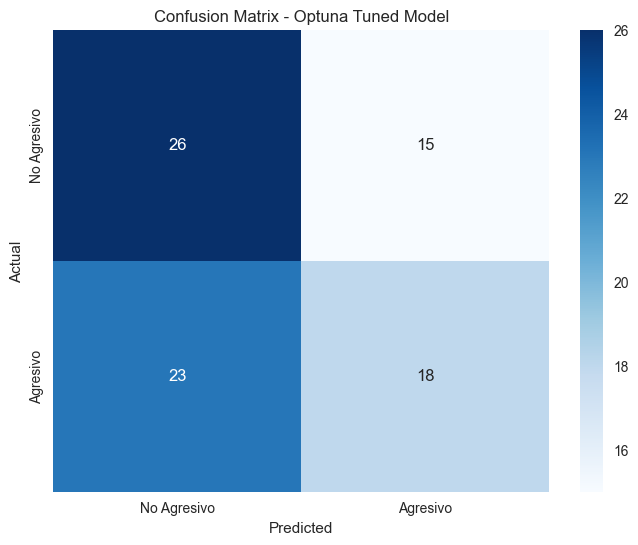

In [30]:
cm = confusion_matrix(y_test, y_pred_optuna)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Agresivo', 'Agresivo'], yticklabels=['No Agresivo', 'Agresivo'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Optuna Tuned Model')
plt.show()

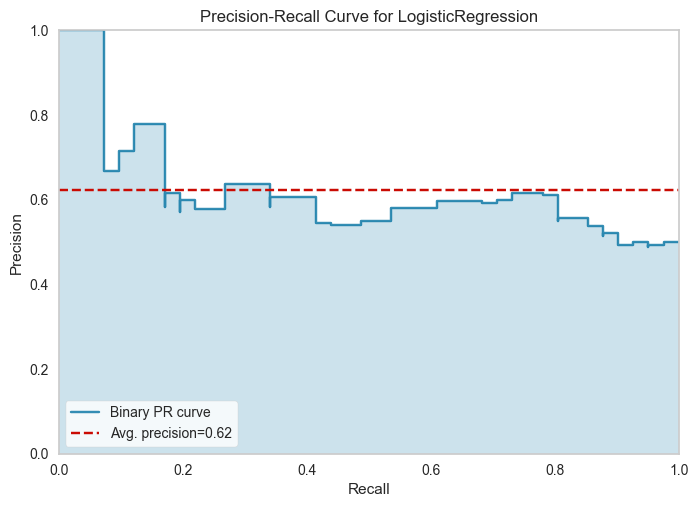

In [31]:
plot_model(best_model_optuna, plot='pr')

In [32]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_optuna))

              precision    recall  f1-score   support

       False       0.53      0.63      0.58        41
        True       0.55      0.44      0.49        41

    accuracy                           0.54        82
   macro avg       0.54      0.54      0.53        82
weighted avg       0.54      0.54      0.53        82



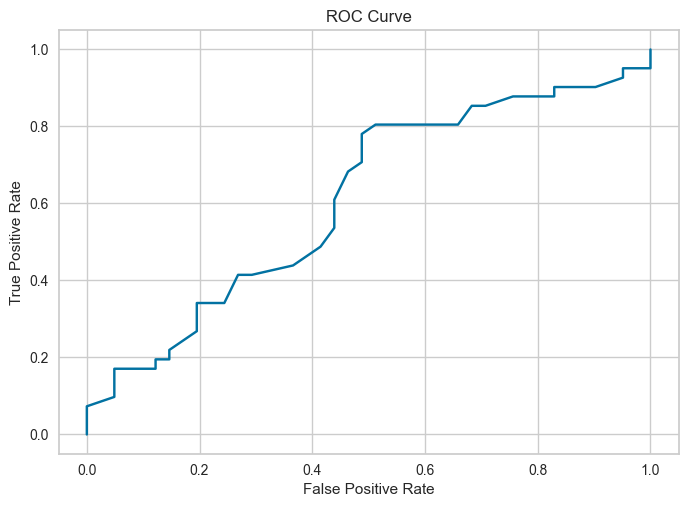

In [33]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_optuna)
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

CAMBIO UMBRALES

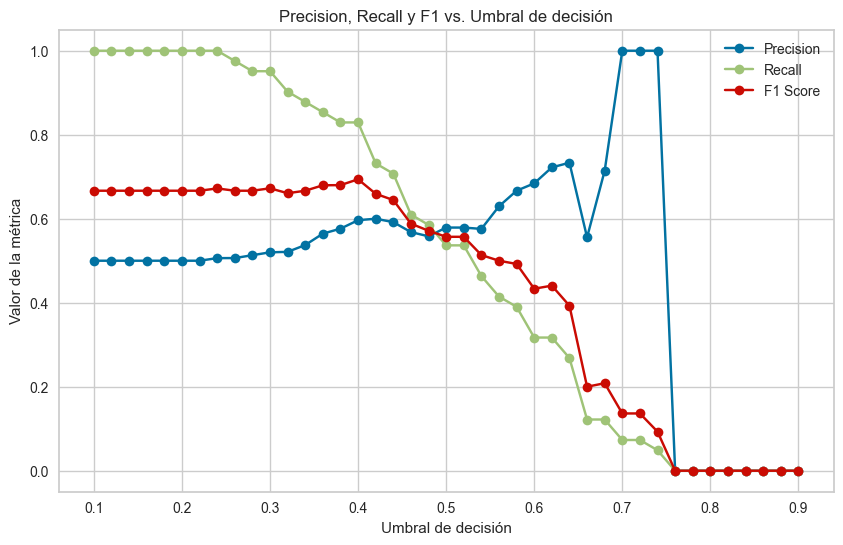

In [34]:
thresholds = np.arange(0.1, 0.91, 0.02) #distintos umbrales de decisión
precisions = []
recalls = []
f1s = []

for thresh in thresholds:
    y_pred = (y_probas >= thresh).astype(int) #comparo probabilidades con el umbral, mayor probabilidad es agrisivo, menor es no agresivo
    precisions.append(precision_score(y_test, y_pred)) #precisión de las positivas (nº de correctas)
    recalls.append(recall_score(y_test, y_pred)) #recall de las positivas (cuantos positivos he detectado)
    f1s.append(f1_score(y_test, y_pred))

plt.figure(figsize=(10,6))
plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='o')
plt.plot(thresholds, f1s, label='F1 Score', marker='o')
plt.xlabel('Umbral de decisión')
plt.ylabel('Valor de la métrica')
plt.title('Precision, Recall y F1 vs. Umbral de decisión')
plt.legend()
plt.grid(True)
plt.show()


              precision    recall  f1-score   support

       False       0.61      0.54      0.57        41
        True       0.59      0.66      0.62        41

    accuracy                           0.60        82
   macro avg       0.60      0.60      0.60        82
weighted avg       0.60      0.60      0.60        82



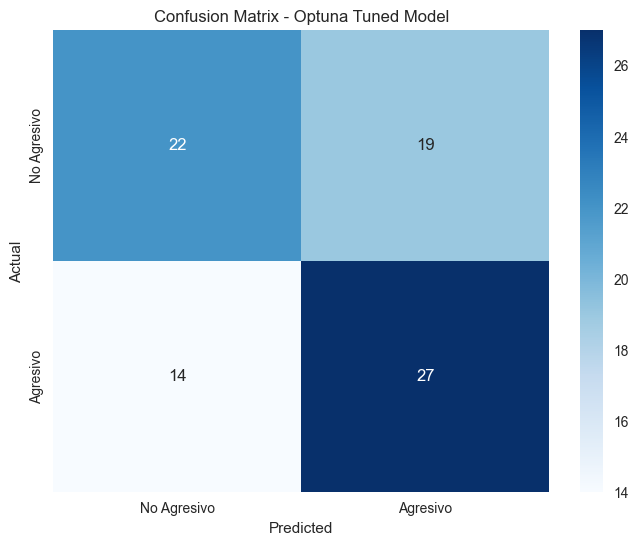

In [41]:
umbral = 0.45
y_pred_34 = (y_probas >= umbral).astype(int)
print(classification_report(y_test, y_pred_34))
cm = confusion_matrix(y_test, y_pred_34)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Agresivo', 'Agresivo'], yticklabels=['No Agresivo', 'Agresivo'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Optuna Tuned Model')
plt.show()

IMPORTANCIA DE LO FEATURES
- azul = mayor contribución
- rojo = menor contribución

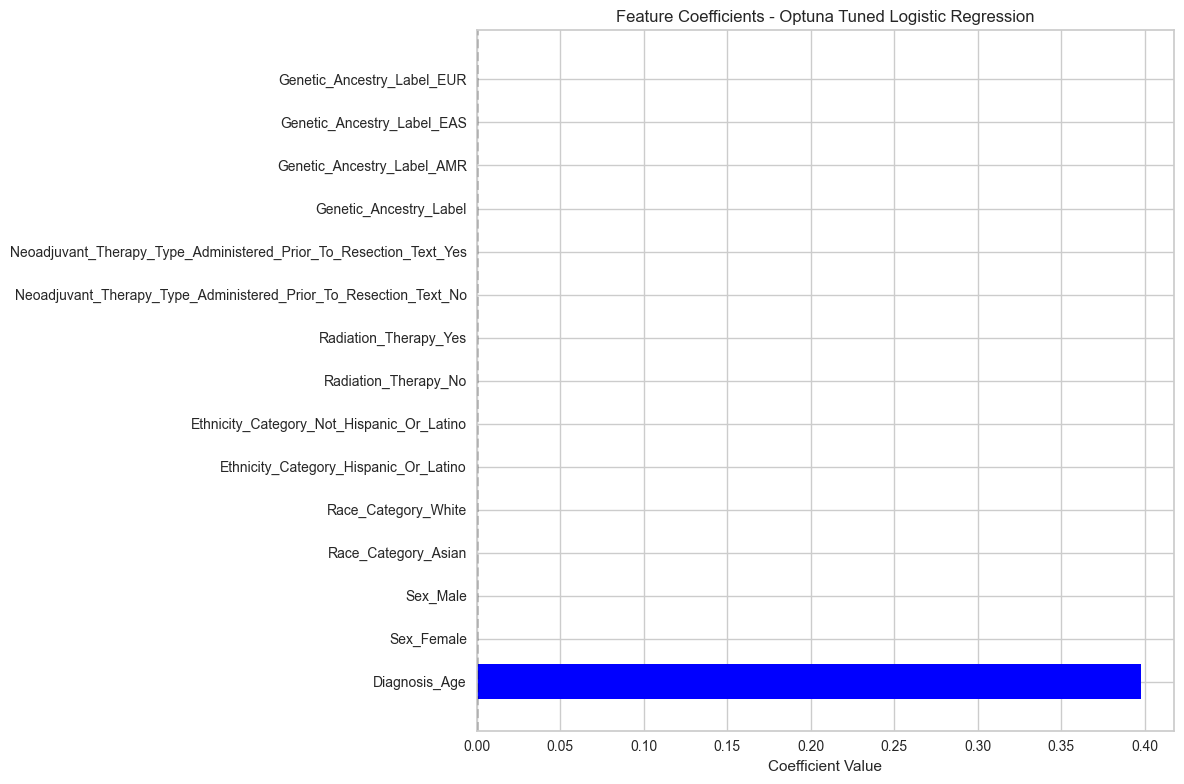

In [36]:
feature_names = df_final_train.drop(columns=['trueTarget']).columns
coeficientes = best_model_optuna.coef_[0]
coeficientes_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coeficientes
}).sort_values(by='Coefficient', ascending=False)
colores = ['blue' if coef >= 0 else 'red' for coef in coeficientes_df['Coefficient']]
plt.figure(figsize=(12, 8))
plt.barh(coeficientes_df['Feature'], coeficientes_df['Coefficient'], color=colores)
plt.xlabel('Coefficient Value')
plt.title('Feature Coefficients - Optuna Tuned Logistic Regression')
plt.axvline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()